%% [markdown]<br>
# Exploring PCA on Plant Trait Data<br>
<br>
This notebook explores how different input trait combinations and PCA parameters affect the resulting principal components for our plant trait analysis. We'll use the TRY database data that has been processed as part of our pipeline.<br>
<br>
We'll explore:<br>
1. How different trait selections impact the resulting principal components<br>
2. How the number of principal components (or explained variance threshold) affects our results<br>
3. The trade-off between dimensionality reduction and information retention<br>
4. How different plant functional types might cluster in PCA space

%%<br>
Import required libraries

In [1]:
import zipfile
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
from src.conf.conf import get_config
from src.conf.environment import log
from src.utils.df_utils import filter_outliers
from src.utils.trait_utils import (
    clean_species_name,
    filter_pft
)

Set plot style

In [4]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("notebook", font_scale=1.2)

Configure plots to be larger and more readable

In [5]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

%% [markdown]<br>
## Data Loading<br>
<br>
First, we'll load the TRY database data. We'll use the same approach as in `build_try_traits.py`.

%%<br>
Load configuration

In [6]:
cfg = get_config()
try_version = cfg.try_version
try_params = f"try{try_version}"
try_raw_dir = Path(cfg.raw_dir, cfg.trydb.raw[try_params].dir)
try_prep_dir = Path(cfg.interim_dir, cfg.trydb.interim.dir)

In [7]:
print(f"Using TRY database version: {try_version}")
print(f"Raw data directory: {try_raw_dir}")
print(f"Interim data directory: {try_prep_dir}")

Using TRY database version: 5
Raw data directory: data/raw/TRY_5_GapFilledData_2020
Interim data directory: data/interim/try


Function to load trait data directly

In [13]:
def load_try_data():
    """Load TRY trait data from raw files."""

    # # If we already have preprocessed data, use that instead
    # processed_file = try_prep_dir / cfg.trydb.interim.filtered
    # if processed_file.exists():
    #     print(f"Loading pre-processed trait data from {processed_file}")
    #     return pd.read_parquet(processed_file)

    # Define trait columns based on TRY version
    if try_version == 6:
        trait_cols = [f"X.X{t}." for t in cfg.datasets.Y.traits]
    else:
        trait_cols = [f"X{t}" for t in cfg.datasets.Y.traits]
    trait_cols = ["Species"] + trait_cols
    print(f"Loading traits: {cfg.datasets.Y.traits}")

    # Extract and load data from the ZIP file
    with zipfile.ZipFile(try_raw_dir / cfg.trydb.raw[try_params].zip, "r") as zip_ref:
        with zip_ref.open(cfg.trydb.raw[try_params].zipfile_csv) as zf:
            if try_version == 6:
                with zipfile.ZipFile(zf, "r") as nested_zip_ref:
                    with nested_zip_ref.open(nested_zip_ref.namelist()[0]) as csvfile:
                        traits = pd.read_csv(
                            csvfile,
                            encoding="latin-1",
                            usecols=trait_cols,
                        )
            else:
                traits = pd.read_csv(zf, encoding="latin-1", usecols=trait_cols)

    # Standardize trait IDs
    traits = traits.astype({"Species": "string[pyarrow]"})

    # Clean and process traits
    # Standardize trait IDs between TRY5 and TRY6
    old_trait_cols = traits.columns[traits.columns.str.startswith("X")]
    new_trait_cols = [col.split(".")[1] for col in old_trait_cols if "." in col]
    if new_trait_cols:
        traits = traits.rename(columns=dict(zip(old_trait_cols, new_trait_cols)))

    # Filter outliers if specified
    if cfg.trydb.interim.quantile_range:
        numeric_cols = [
            col
            for col in traits.columns
            if col != "Species" and pd.api.types.is_numeric_dtype(traits[col])
        ]
        traits = filter_outliers(
            traits, cols=numeric_cols, quantiles=cfg.trydb.interim.quantile_range
        )

    # Clean species names and compute means
    traits = (
        traits.pipe(clean_species_name, "Species", "speciesname")
        .drop(columns=["Species"])
        .groupby("speciesname")
        .mean()
        .reset_index()
    )

    # Load and filter by PFTs
    pft_path = Path(cfg.raw_dir, cfg.trydb.raw.pfts)
    pft_columns = ["AccSpeciesName", "pft"]
    if pft_path.suffix == ".csv":
        pfts = pd.read_csv(pft_path, encoding="latin-1", usecols=pft_columns)
    else:
        pfts = pd.read_parquet(pft_path, columns=pft_columns)
    pfts = (
        pfts.pipe(filter_pft, cfg.PFT)
        .astype({"AccSpeciesName": "string[pyarrow]", "pft": "category"})
        .dropna(subset=["AccSpeciesName"])
        .pipe(clean_species_name, "AccSpeciesName", "speciesname")
        .drop(columns=["AccSpeciesName"])
    )

    # Merge with traits
    traits = traits.merge(pfts, on="speciesname", how="inner")
    return traits

Load the data

In [14]:
try_data = load_try_data()

Loading traits: [4, 6, 11, 13, 14, 15, 18, 21, 26, 27, 46, 47, 50, 55, 78, 95, 138, 144, 145, 146, 163, 169, 237, 281, 282, 289, 1080, 3113, 3120]


%% [markdown]<br>
## Data Exploration and Preprocessing<br>
<br>
Let's explore the data before diving into PCA. We'll check the shape, distribution of traits, and missing values.

%%<br>
Basic data exploration

In [15]:
print(f"Dataset shape: {try_data.shape}")
print(f"Number of unique species: {try_data['speciesname'].nunique()}")

Dataset shape: (42139, 31)
Number of unique species: 38035



Plant Functional Type (PFT) distribution:
pft
Grass    19929
Tree     12776
Shrub     9434
Name: count, dtype: int64


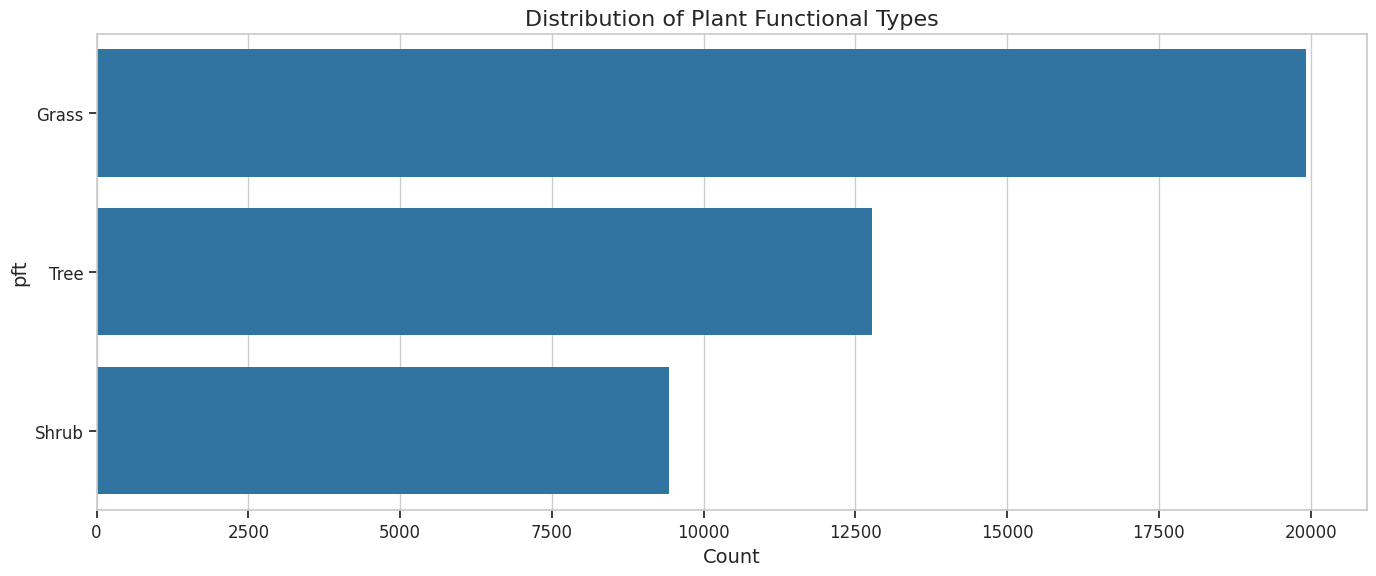

In [16]:
if "pft" in try_data.columns:
    print("\nPlant Functional Type (PFT) distribution:")
    pft_counts = try_data["pft"].value_counts()
    print(pft_counts)

    # Visualize PFT distribution
    plt.figure(figsize=(14, 6))
    sns.countplot(y="pft", data=try_data, order=pft_counts.index)
    plt.title("Distribution of Plant Functional Types")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

%% [markdown]<br>
### Examining Traits and Missing Values

%%<br>
Get trait columns (those starting with X)

In [17]:
trait_cols = [col for col in try_data.columns if col.startswith("X")]
print(f"Number of trait columns: {len(trait_cols)}")
print(f"Trait columns: {trait_cols}")

Number of trait columns: 29
Trait columns: ['X4', 'X6', 'X11', 'X13', 'X14', 'X15', 'X18', 'X21', 'X26', 'X27', 'X46', 'X47', 'X50', 'X55', 'X78', 'X95', 'X138', 'X144', 'X145', 'X146', 'X163', 'X169', 'X237', 'X281', 'X282', 'X289', 'X1080', 'X3113', 'X3120']


Check missing values

In [18]:
missing_data = try_data[trait_cols].isna().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(try_data)) * 100

In [19]:
missing_summary = pd.DataFrame(
    {"Missing Values": missing_data, "Percent Missing": missing_percent}
)

In [20]:
print("\nMissing values by trait:")
print(missing_summary.head(10))  # Show top 10 with most missing values


Missing values by trait:
     Missing Values  Percent Missing
X4                0              0.0
X6                0              0.0
X11               0              0.0
X13               0              0.0
X14               0              0.0
X15               0              0.0
X18               0              0.0
X21               0              0.0
X26               0              0.0
X27               0              0.0


Visualize missing data

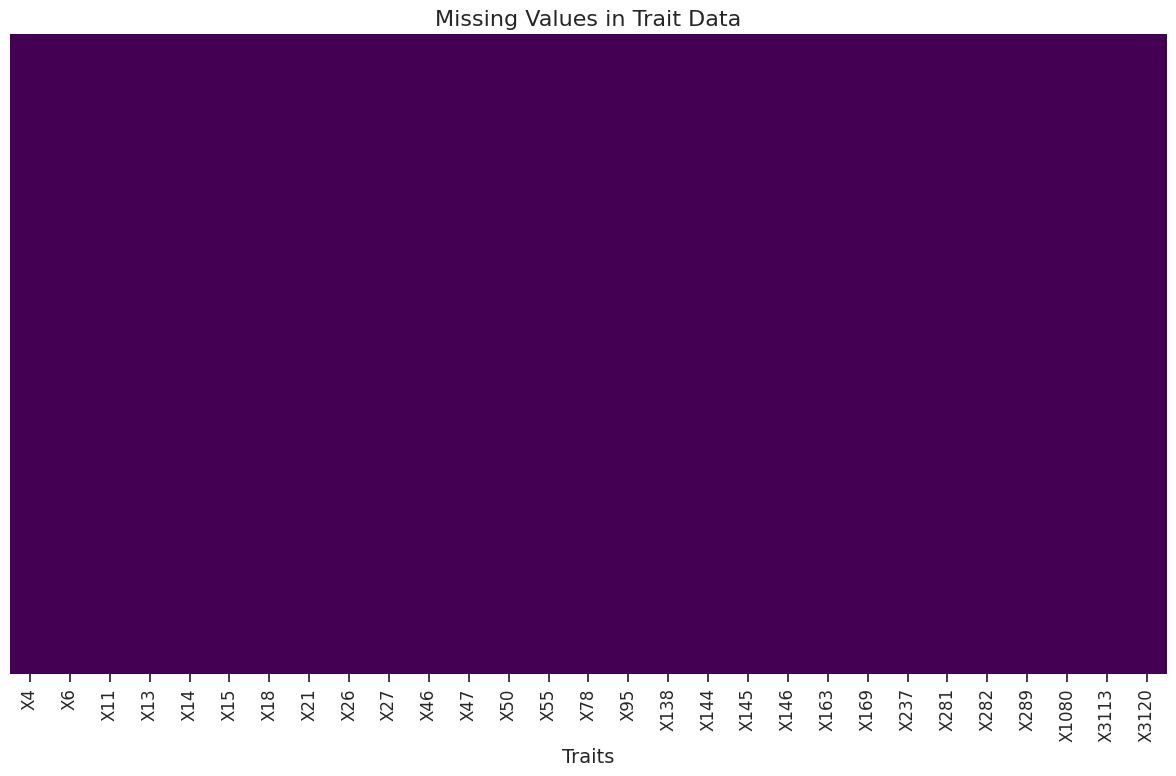

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(try_data[trait_cols].isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Missing Values in Trait Data")
plt.xlabel("Traits")
plt.tight_layout()
plt.show()

%% [markdown]<br>
### Trait Distributions and Correlations<br>
<br>
Let's look at the distribution of each trait and the correlations between traits.

%%<br>
Distribution of each trait

In [22]:
trait_data = try_data[trait_cols].copy()

Plot distributions for a subset of traits (first 6 or fewer)

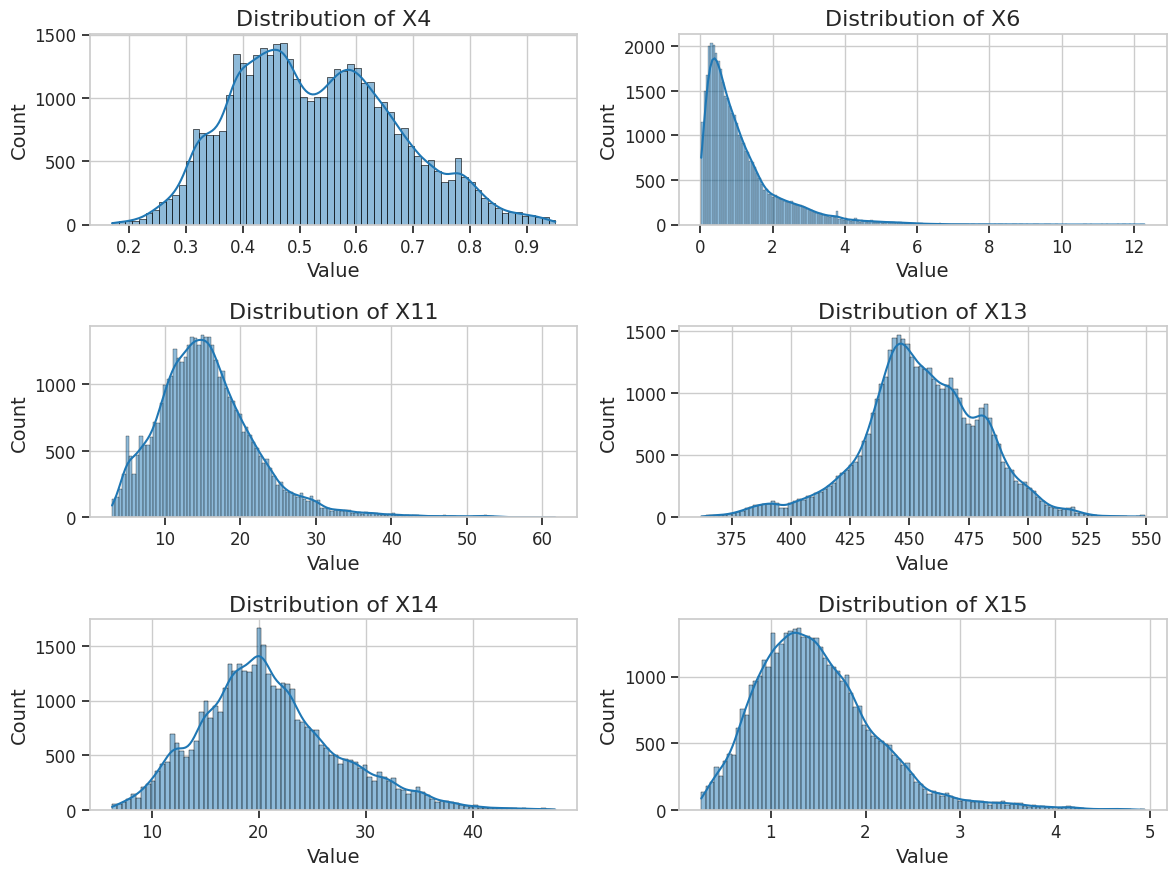

In [34]:
sample_traits = trait_cols[: min(6, len(trait_cols))]
fig, axes = plt.subplots(len(sample_traits) // 2, 2, figsize=(12, 3 * (len(sample_traits) // 2)))
axes = axes.flatten()
if len(sample_traits) == 1:
    axes = [axes]  # Make it indexable if only one subplot
for i, trait in enumerate(sample_traits):
    sns.histplot(trait_data[trait].dropna(), ax=axes[i], kde=True)
    axes[i].set_title(f"Distribution of {trait}")
    axes[i].set_xlabel("Value")
plt.tight_layout()
plt.show()

Correlation matrix

In [35]:
corr_matrix = trait_data.corr(method="pearson")

Plot correlation heatmap

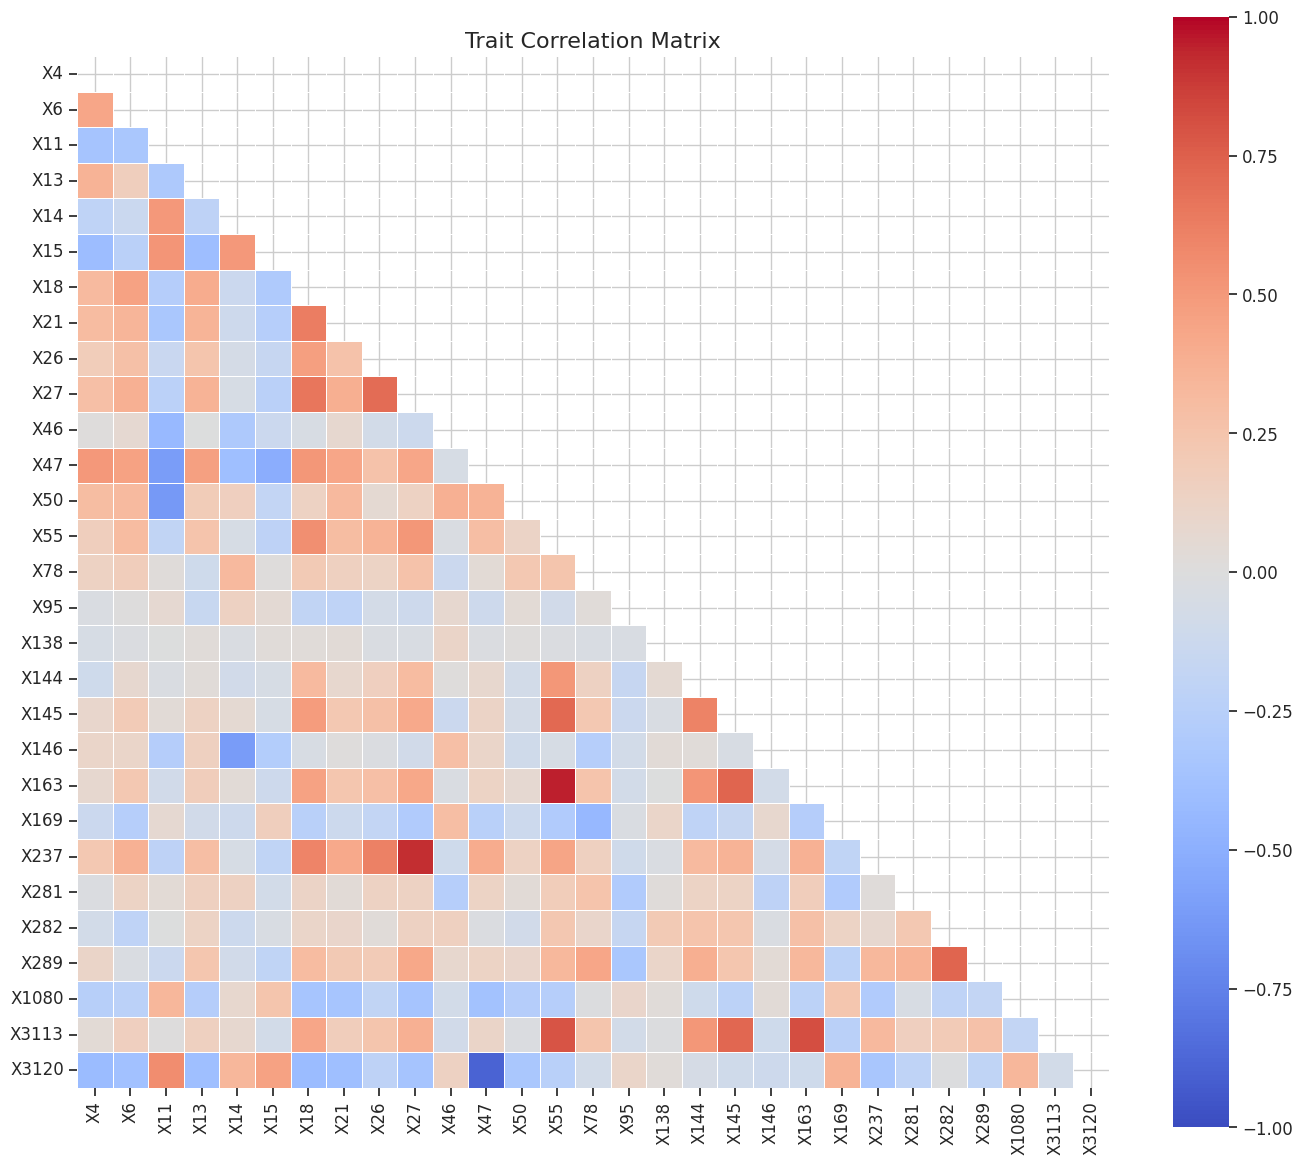

In [36]:
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    annot=False,
    square=True,
    linewidths=0.5,
)
plt.title("Trait Correlation Matrix")
plt.tight_layout()
plt.show()

%% [markdown]<br>
## Data Normalization<br>
<br>
Before performing PCA, we need to normalize the data. We'll compare different normalization techniques.

%%<br>
Function to normalize data using different methods

In [37]:
def normalize_data(data, method="standard"):
    """Normalize data using different methods."""
    # Work only with numeric columns
    numeric_data = data.select_dtypes(include=[np.number])
    if method == "standard":
        scaler = StandardScaler()
        normalized = scaler.fit_transform(numeric_data)
        scaler_name = "StandardScaler"
    elif method == "minmax":
        scaler = MinMaxScaler(feature_range=(0, 1))
        normalized = scaler.fit_transform(numeric_data)
        scaler_name = "MinMaxScaler"
    else:
        raise ValueError(f"Unknown normalization method: {method}")

    # Create DataFrame with normalized data
    normalized_df = pd.DataFrame(
        normalized, columns=numeric_data.columns, index=numeric_data.index
    )

    # Log normalization stats
    if method == "standard":
        print(
            f"Original data means: [{np.min(scaler.mean_):.4f}, {np.max(scaler.mean_):.4f}]"
        )
        print(
            f"Original data std devs: [{np.min(scaler.scale_):.4f}, {np.max(scaler.scale_):.4f}]"
        )
    elif method == "minmax":
        print(
            f"Original data mins: [{np.min(scaler.data_min_):.4f}, {np.max(scaler.data_min_):.4f}]"
        )
        print(
            f"Original data maxs: [{np.min(scaler.data_max_):.4f}, {np.max(scaler.data_max_):.4f}]"
        )

    # Verify transformation
    means = normalized_df.mean()
    stds = normalized_df.std()
    if method == "standard":
        print(
            f"After normalization - mean range: [{means.min():.4f}, {means.max():.4f}] (should be ~0)"
        )
        print(
            f"After normalization - std range: [{stds.min():.4f}, {stds.max():.4f}] (should be ~1)"
        )
    elif method == "minmax":
        print(
            f"After normalization - min value: {normalized_df.min().min():.4f} (should be 0)"
        )
        print(
            f"After normalization - max value: {normalized_df.max().max():.4f} (should be 1)"
        )
    return normalized_df, scaler

Create a copy of the trait data with species info

In [38]:
data_for_norm = try_data.copy()

Compare different normalization methods

In [39]:
print("StandardScaler normalization:")
standard_normalized, std_scaler = normalize_data(
    data_for_norm[trait_cols], method="standard"
)

StandardScaler normalization:
Original data means: [0.0930, 4261.9621]
Original data std devs: [0.0913, 36056.2114]
After normalization - mean range: [-0.0000, 0.0000] (should be ~0)
After normalization - std range: [1.0000, 1.0000] (should be ~1)


In [40]:
print("\nMinMaxScaler normalization:")
minmax_normalized, mm_scaler = normalize_data(
    data_for_norm[trait_cols], method="minmax"
)


MinMaxScaler normalization:
Original data mins: [-6.3315, 362.1871]
Original data maxs: [0.5453, 1638445.1900]
After normalization - min value: 0.0000 (should be 0)
After normalization - max value: 1.0000 (should be 1)


Visualize normalized data distributions

Original, StandardScaler, and MinMaxScaler for 3 random traits

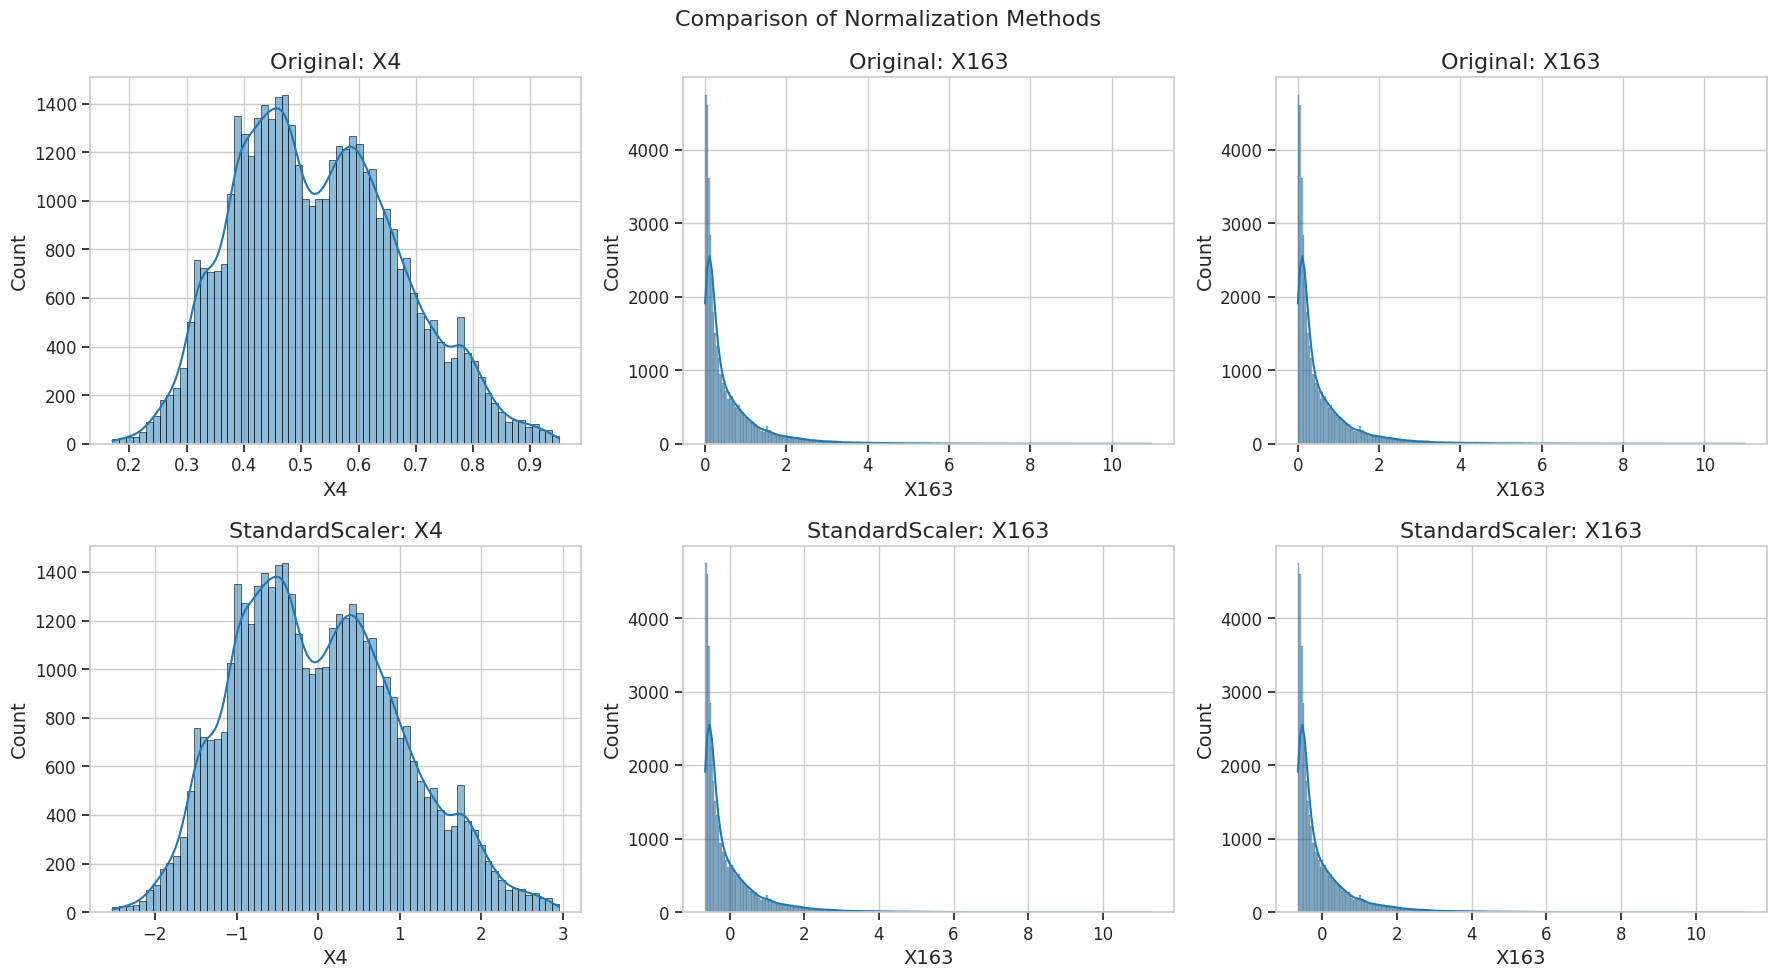

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Comparison of Normalization Methods", fontsize=16)
sample_traits = np.random.choice(trait_cols, 3)
for i, trait in enumerate(sample_traits):
    # Original data
    sns.histplot(data_for_norm[trait].dropna(), kde=True, ax=axes[0, i])
    axes[0, i].set_title(f"Original: {trait}")

    # Standardized data
    sns.histplot(standard_normalized[trait].dropna(), kde=True, ax=axes[1, i])
    axes[1, i].set_title(f"StandardScaler: {trait}")
plt.tight_layout()
plt.show()

%% [markdown]<br>
## Exploring PCA with Different Parameters<br>
<br>
Now let's explore how different PCA parameters affect the results. We'll vary:<br>
1. The number of components or explained variance ratio<br>
2. The subset of traits used

%%<br>
Function to perform PCA and return results

In [43]:
def perform_pca(data, n_components=None, explained_variance=None):
    """
    Perform PCA on the data and return results.
    Parameters:
        data: DataFrame with normalized trait data
        n_components: Number of components to keep (integer)
        explained_variance: Ratio of explained variance to maintain (float)
    Returns:
        pca: Fitted PCA object
        transformed: Transformed data
        component_df: DataFrame with component loadings
    """
    # Set PCA parameters
    if explained_variance is not None:
        pca = PCA(n_components=explained_variance)
    elif n_components is not None:
        pca = PCA(n_components=n_components)
    else:
        pca = PCA()  # Keep all components

    # Fit and transform
    transformed = pca.fit_transform(data)

    # Create component names
    component_names = [f"PC{i + 1}" for i in range(pca.n_components_)]

    # Create DataFrame with transformed data
    transformed_df = pd.DataFrame(
        transformed, columns=component_names, index=data.index
    )

    # Create DataFrame with component loadings
    loadings = pd.DataFrame(
        pca.components_.T, columns=component_names, index=data.columns
    )

    # Report explained variance
    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)
    print(f"Number of components: {pca.n_components_}")
    print(f"Explained variance by first 5 components: {explained_var[:5].round(4)}")
    print(f"Cumulative explained variance: {cumulative_var[:5].round(4)}")
    return pca, transformed_df, loadings

%% [markdown]<br>
### Experiment 1: Varying the Explained Variance Threshold

%%<br>
Use the standardized data for PCA

In [44]:
normalized_data = standard_normalized

Try different explained variance thresholds

In [45]:
variance_thresholds = [0.7, 0.8, 0.9, 0.95, 0.99]

In [46]:
pca_results = {}
for threshold in variance_thresholds:
    print(f"\n=== PCA with {threshold:.0%} explained variance ===")
    pca, transformed, loadings = perform_pca(
        normalized_data, explained_variance=threshold
    )
    pca_results[threshold] = (pca, transformed, loadings)


=== PCA with 70% explained variance ===
Number of components: 8
Explained variance by first 5 components: [0.2559 0.1326 0.0812 0.0641 0.0578]
Cumulative explained variance: [0.2559 0.3885 0.4697 0.5338 0.5916]

=== PCA with 80% explained variance ===
Number of components: 11
Explained variance by first 5 components: [0.2559 0.1326 0.0812 0.0641 0.0578]
Cumulative explained variance: [0.2559 0.3885 0.4697 0.5338 0.5916]

=== PCA with 90% explained variance ===
Number of components: 16
Explained variance by first 5 components: [0.2559 0.1326 0.0812 0.0641 0.0578]
Cumulative explained variance: [0.2559 0.3885 0.4697 0.5338 0.5916]

=== PCA with 95% explained variance ===
Number of components: 19
Explained variance by first 5 components: [0.2559 0.1326 0.0812 0.0641 0.0578]
Cumulative explained variance: [0.2559 0.3885 0.4697 0.5338 0.5916]

=== PCA with 99% explained variance ===
Number of components: 25
Explained variance by first 5 components: [0.2559 0.1326 0.0812 0.0641 0.0578]
Cumu

Visualize number of components needed for different thresholds

In [47]:
thresholds = list(pca_results.keys())
n_components = [pca_results[t][0].n_components_ for t in thresholds]

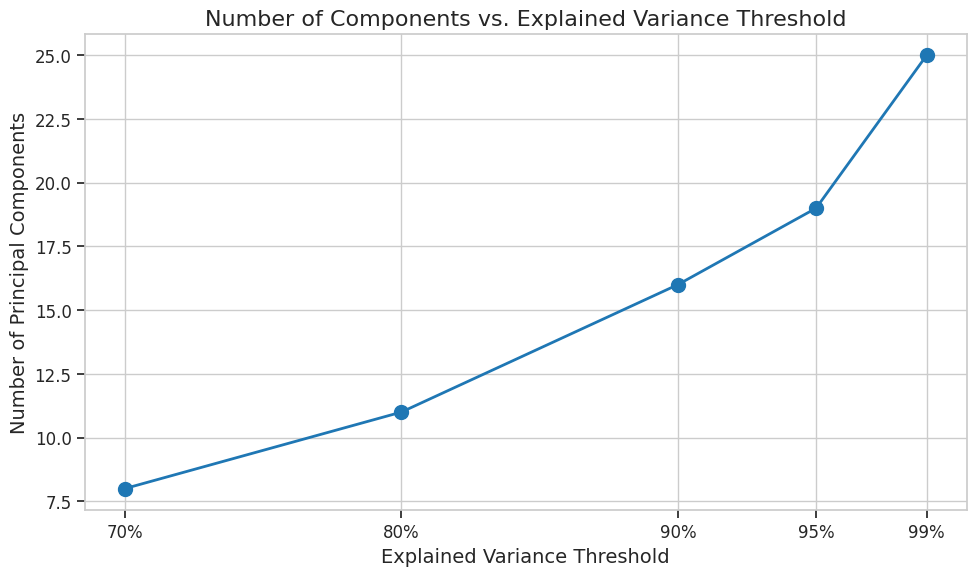

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, n_components, "o-", linewidth=2, markersize=10)
plt.xlabel("Explained Variance Threshold")
plt.ylabel("Number of Principal Components")
plt.title("Number of Components vs. Explained Variance Threshold")
plt.grid(True)
plt.xticks(thresholds, [f"{t:.0%}" for t in thresholds])
plt.tight_layout()
plt.show()

%% [markdown]<br>
### Experiment 2: Analyzing Component Loadings<br>
<br>
Let's examine the loadings of the principal components to understand which traits contribute the most to each component.

%%<br>
Select a threshold to analyze in detail (e.g., 0.9)

In [49]:
threshold = 0.9
pca, transformed, loadings = pca_results[threshold]

Show top contributing traits for each component

In [50]:
def top_contributing_traits(loadings, n_traits=5):
    """Find top contributing traits for each principal component."""
    results = []
    for component in loadings.columns:
        # Get absolute loadings and sort
        abs_loadings = loadings[component].abs().sort_values(ascending=False)
        top_traits = abs_loadings.head(n_traits)

        # Get signs
        signs = loadings[component].loc[top_traits.index] > 0
        sign_symbols = ["+" if s else "-" for s in signs]

        # Combine trait, sign and loading value
        trait_contributions = [
            f"{trait} ({sign}{loading:.3f})"
            for trait, sign, loading in zip(
                top_traits.index, sign_symbols, top_traits.values
            )
        ]
        results.append((component, trait_contributions))
    return results

Get top traits for each component

In [51]:
top_traits = top_contributing_traits(loadings, n_traits=5)

Display results in a table

In [52]:
top_trait_df = pd.DataFrame(
    [
        {
            "Component": comp,
            "Explained Variance": f"{pca.explained_variance_ratio_[int(comp[2:]) - 1]:.2%}",
            "Top Traits": ", ".join(traits),
        }
        for comp, traits in top_traits
    ]
)

In [53]:
print("Top contributing traits for each principal component:")
print(top_trait_df.head())

Top contributing traits for each principal component:
  Component Explained Variance  \
0       PC1             25.59%   
1       PC2             13.26%   
2       PC3              8.12%   
3       PC4              6.41%   
4       PC5              5.78%   

                                          Top Traits  
0  X18 (+0.291), X27 (+0.289), X55 (+0.276), X237...  
1  X11 (+0.332), X14 (+0.282), X3113 (+0.278), X1...  
2  X14 (-0.376), X282 (+0.372), X146 (+0.340), X4...  
3  X289 (+0.458), X281 (+0.421), X282 (+0.382), X...  
4  X50 (+0.524), X46 (+0.466), X11 (-0.255), X95 ...  


Visualize loadings for the first 2 components

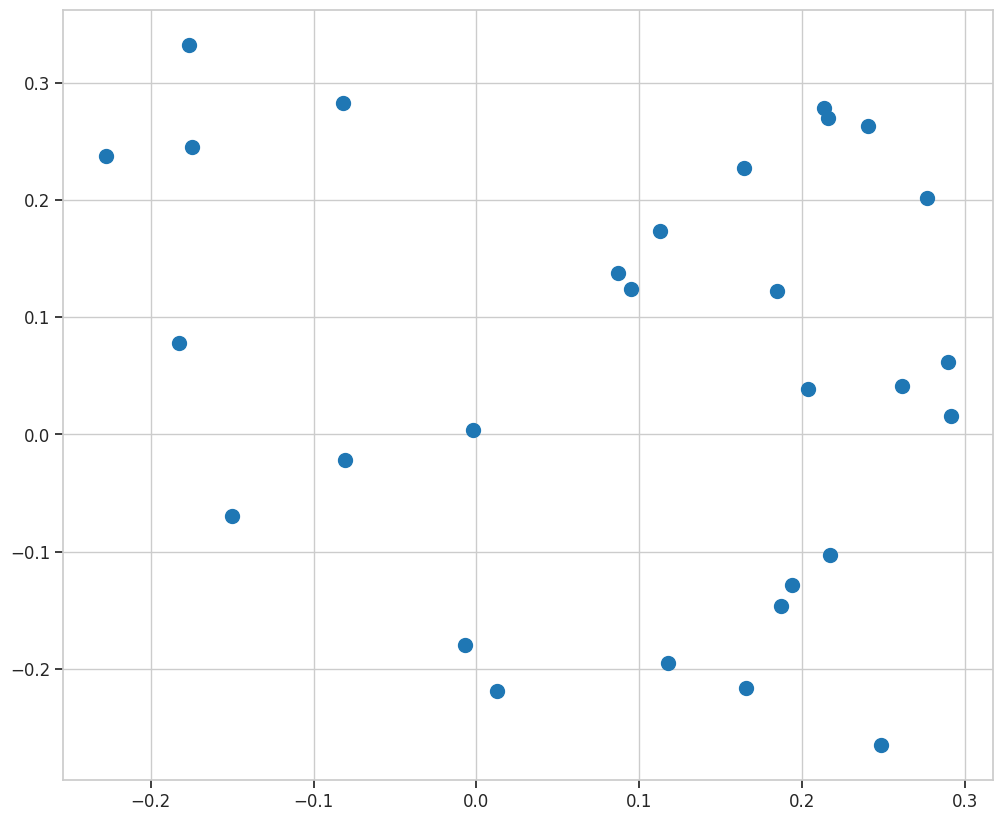

In [54]:
plt.figure(figsize=(12, 10))
plt.scatter(loadings["PC1"], loadings["PC2"], s=100)

Add trait labels

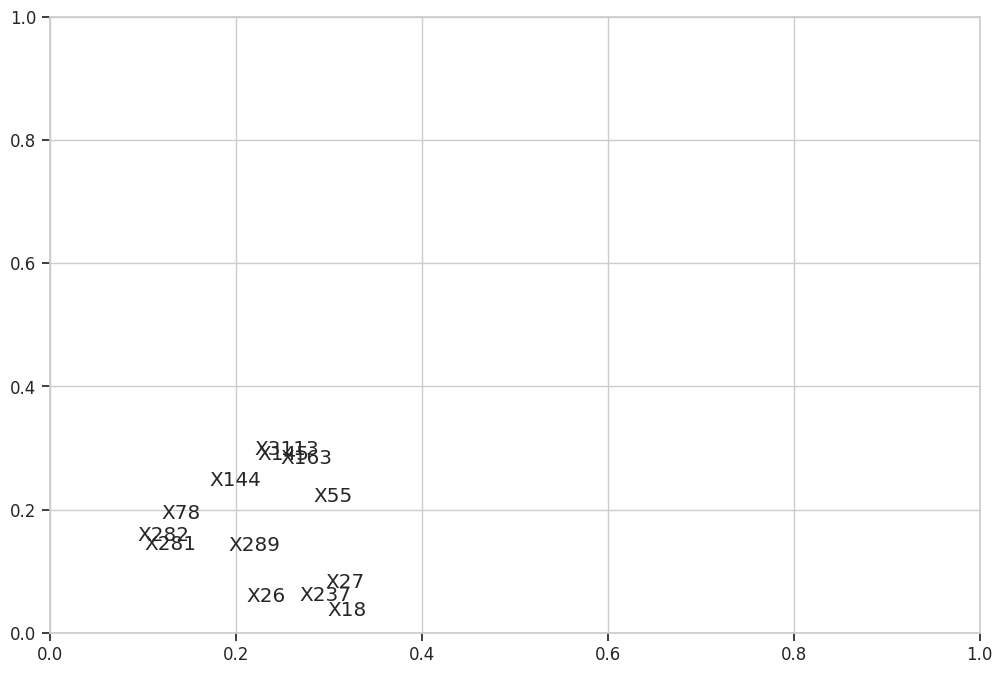

In [55]:
for trait in loadings.index:
    plt.annotate(
        trait,
        xy=(loadings.loc[trait, "PC1"], loadings.loc[trait, "PC2"]),
        xytext=(5, 5),
        textcoords="offset points",
    )

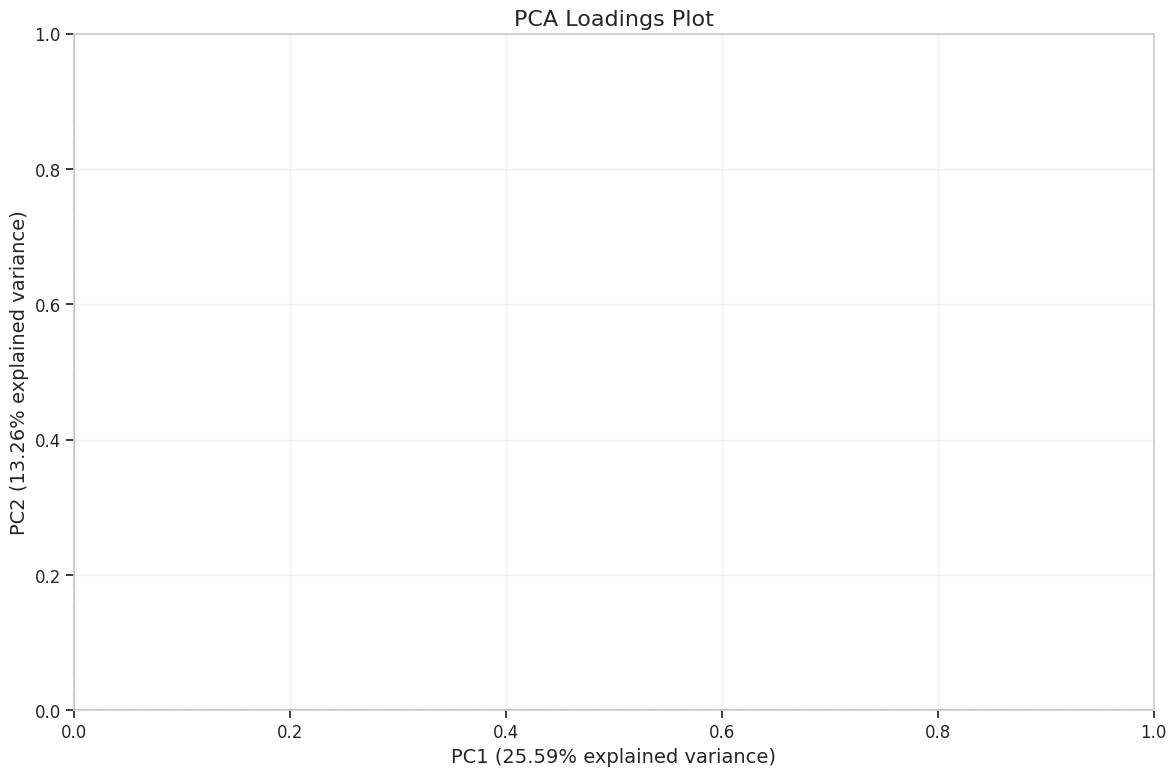

In [56]:
plt.axhline(y=0, color="k", linestyle="--", alpha=0.3)
plt.axvline(x=0, color="k", linestyle="--", alpha=0.3)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)")
plt.title("PCA Loadings Plot")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

%% [markdown]<br>
### Experiment 3: Visualizing Species in PCA Space<br>
<br>
Let's project the species into the PCA space to see how they cluster by plant functional type.

%%<br>
Add species information to the transformed data

In [57]:
pca_with_metadata = transformed.copy()
pca_with_metadata["speciesname"] = try_data["speciesname"].values

In [58]:
if "pft" in try_data.columns:
    pca_with_metadata["pft"] = try_data["pft"].values

Scatterplot of first two components colored by PFT

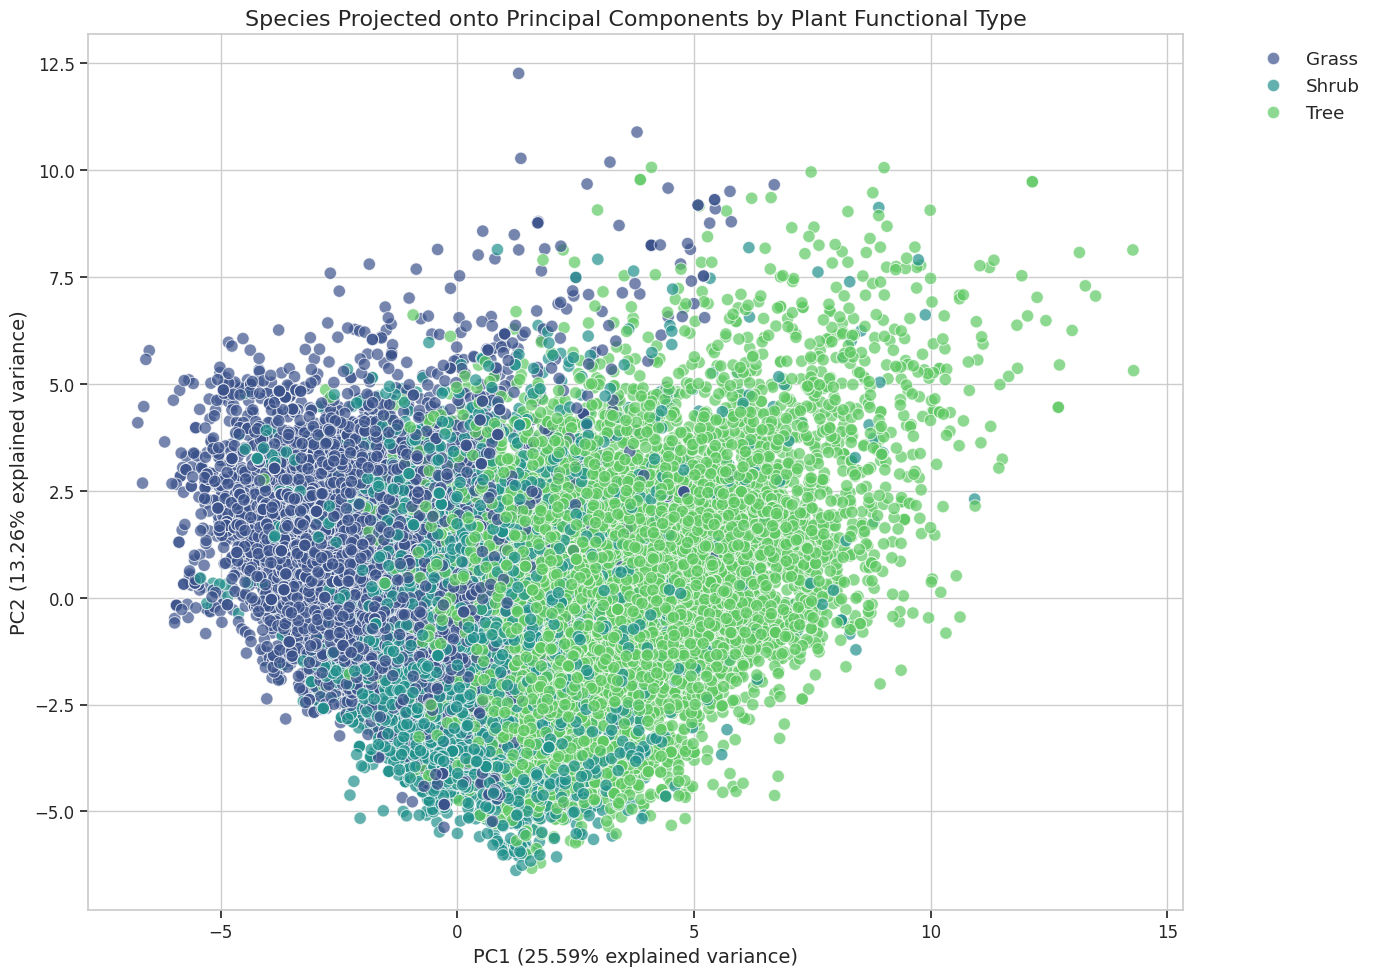

In [59]:
if "pft" in pca_with_metadata.columns:
    plt.figure(figsize=(14, 10))

    # Plot with seaborn to get better legend
    scatter = sns.scatterplot(
        data=pca_with_metadata,
        x="PC1",
        y="PC2",
        hue="pft",
        palette="viridis",
        alpha=0.7,
        s=80,
    )
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)")
    plt.title("Species Projected onto Principal Components by Plant Functional Type")

    # Move legend outside
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

%% [markdown]<br>
### Experiment 4: Different Trait Subsets for PCA<br>
<br>
Let's explore how selecting different subsets of traits affects our PCA results.

%%<br>
Function to select trait subsets

In [60]:
def get_trait_subsets():
    """Generate different subsets of traits for analysis."""
    all_traits = standard_normalized.columns.tolist()

    # Create a few subsets
    n_traits = len(all_traits)

    # Subset 1: First half of traits
    subset1 = all_traits[: n_traits // 2]

    # Subset 2: Second half of traits
    subset2 = all_traits[n_traits // 2 :]

    # Subset 3: Random 70% of traits
    subset3 = np.random.choice(all_traits, int(n_traits * 0.7), replace=False).tolist()

    # Return subsets with names
    return {
        "All Traits": all_traits,
        "First Half": subset1,
        "Second Half": subset2,
        "Random 70%": subset3,
    }

In [61]:
trait_subsets = get_trait_subsets()

Perform PCA for each subset with 90% explained variance

In [62]:
subset_results = {}
for name, traits in trait_subsets.items():
    print(f"\n=== PCA with {name} ({len(traits)} traits) ===")
    subset_data = standard_normalized[traits]
    pca, transformed, loadings = perform_pca(subset_data, explained_variance=0.9)
    subset_results[name] = (pca, transformed, loadings)


=== PCA with All Traits (29 traits) ===
Number of components: 16
Explained variance by first 5 components: [0.2559 0.1326 0.0812 0.0641 0.0578]
Cumulative explained variance: [0.2559 0.3885 0.4697 0.5338 0.5916]

=== PCA with First Half (14 traits) ===
Number of components: 9
Explained variance by first 5 components: [0.3558 0.15   0.0964 0.0747 0.0595]
Cumulative explained variance: [0.3558 0.5058 0.6022 0.6769 0.7364]

=== PCA with Second Half (15 traits) ===
Number of components: 10
Explained variance by first 5 components: [0.2766 0.1127 0.1097 0.0949 0.0689]
Cumulative explained variance: [0.2766 0.3893 0.499  0.5939 0.6628]

=== PCA with Random 70% (20 traits) ===
Number of components: 12
Explained variance by first 5 components: [0.2663 0.1384 0.0923 0.0701 0.0641]
Cumulative explained variance: [0.2663 0.4046 0.4969 0.5671 0.6312]


Compare number of components for each subset

In [63]:
subset_names = list(subset_results.keys())
subset_n_components = [subset_results[name][0].n_components_ for name in subset_names]
subset_n_traits = [len(trait_subsets[name]) for name in subset_names]

Create comparison table

In [64]:
comparison_df = pd.DataFrame(
    {
        "Subset": subset_names,
        "Number of Traits": subset_n_traits,
        "Number of Components (90% var)": subset_n_components,
        "Trait to Component Ratio": [
            n_t / n_c for n_t, n_c in zip(subset_n_traits, subset_n_components)
        ],
    }
)

In [65]:
print("\nComparison of trait subsets:")
print(comparison_df)


Comparison of trait subsets:
        Subset  Number of Traits  Number of Components (90% var)  \
0   All Traits                29                              16   
1   First Half                14                               9   
2  Second Half                15                              10   
3   Random 70%                20                              12   

   Trait to Component Ratio  
0                  1.812500  
1                  1.555556  
2                  1.500000  
3                  1.666667  


Visualize comparison

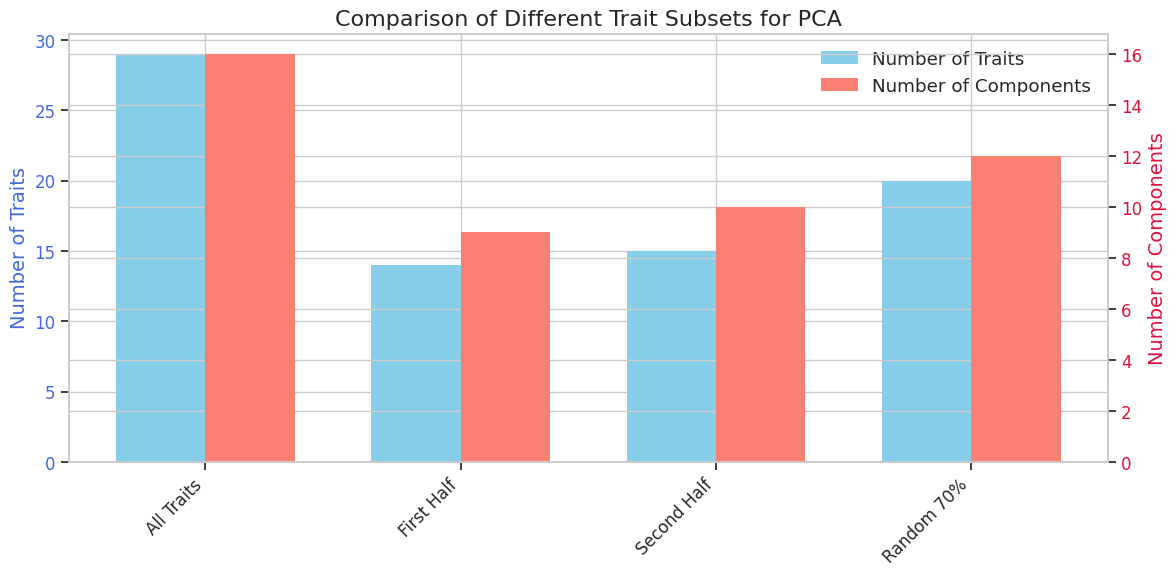

In [81]:
fig, ax1 = plt.subplots(figsize=(12, 6))
x = np.arange(len(subset_names))
bar_width = 0.35
ax1.bar(
    x - bar_width / 2,
    subset_n_traits,
    bar_width,
    label="Number of Traits",
    color="skyblue",
)
ax1.set_ylabel("Number of Traits", color="royalblue")
ax1.tick_params(axis="y", labelcolor="royalblue")
ax2 = ax1.twinx()
ax2.bar(
    x + bar_width / 2,
    subset_n_components,
    bar_width,
    label="Number of Components",
    color="salmon",
)
ax2.set_ylabel("Number of Components", color="crimson")
ax2.tick_params(axis="y", labelcolor="crimson")
ax1.set_xticks(x)
ax1.set_xticklabels(subset_names, rotation=45, ha="right")
plt.title("Comparison of Different Trait Subsets for PCA")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)
plt.tight_layout()
plt.show()

%% [markdown]<br>
### Experiment 5: Comparing PCA Reconstructions<br>
<br>
Let's see how well we can reconstruct the original data using different numbers of principal components.

%%<br>
Function to reconstruct data from PCA and compute reconstruction error

In [73]:
def reconstruct_and_evaluate(pca, transformed_data, original_data, trait_subset=None):
    """
    Reconstruct original data from PCA components and evaluate reconstruction error.
    Parameters:
        pca: Fitted PCA object
        transformed_data: PCA-transformed data
        original_data: Original normalized data
        trait_subset: Optional subset of traits to use
    Returns:
        reconstruction_error: Mean squared error between original and reconstructed data
    """
    if trait_subset is not None:
        original_subset = original_data[trait_subset]
    else:
        original_subset = original_data

    # Reconstruct data using inverse transform
    reconstructed = pca.inverse_transform(transformed_data.values)
    reconstructed_df = pd.DataFrame(
        reconstructed, columns=original_subset.columns, index=original_subset.index
    )

    # Calculate reconstruction error
    mse = ((original_subset - reconstructed_df) ** 2).mean().mean()
    return reconstructed_df, mse

Compare reconstruction error for different numbers of components

In [74]:
explained_variances = [0.7, 0.8, 0.9, 0.95, 0.99]
reconstruction_errors = []

In [75]:
for exp_var in explained_variances:
    pca_obj, transformed, _ = pca_results[exp_var]
    reconstructed, error = reconstruct_and_evaluate(
        pca_obj, transformed, standard_normalized
    )
    reconstruction_errors.append(
        {
            "Explained Variance": exp_var,
            "Components": pca_obj.n_components_,
            "MSE": error,
        }
    )

In [76]:
error_df = pd.DataFrame(reconstruction_errors)
print("Reconstruction errors:")
print(error_df)

Reconstruction errors:
   Explained Variance  Components       MSE
0                0.70           8  0.283982
1                0.80          11  0.192749
2                0.90          16  0.087261
3                0.95          19  0.049183
4                0.99          25  0.006992


Visualize reconstruction errors

([<matplotlib.axis.XTick at 0x7fc9bfca00d0>,
 [Text(0.7, 0, '70%'),
  Text(0.8, 0, '80%'),
  Text(0.9, 0, '90%'),
  Text(0.95, 0, '95%'),
  Text(0.99, 0, '99%')])

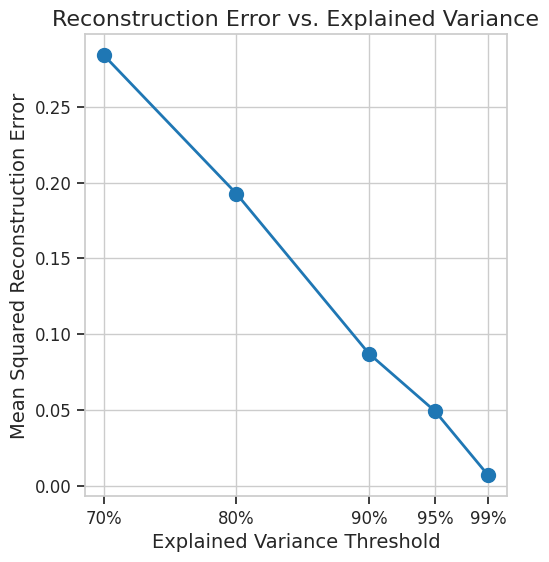

In [77]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(
    [r["Explained Variance"] for r in reconstruction_errors],
    [r["MSE"] for r in reconstruction_errors],
    "o-",
    linewidth=2,
    markersize=10,
)
plt.xlabel("Explained Variance Threshold")
plt.ylabel("Mean Squared Reconstruction Error")
plt.title("Reconstruction Error vs. Explained Variance")
plt.grid(True)
plt.xticks(
    [r["Explained Variance"] for r in reconstruction_errors],
    [f"{r['Explained Variance']:.0%}" for r in reconstruction_errors],
)

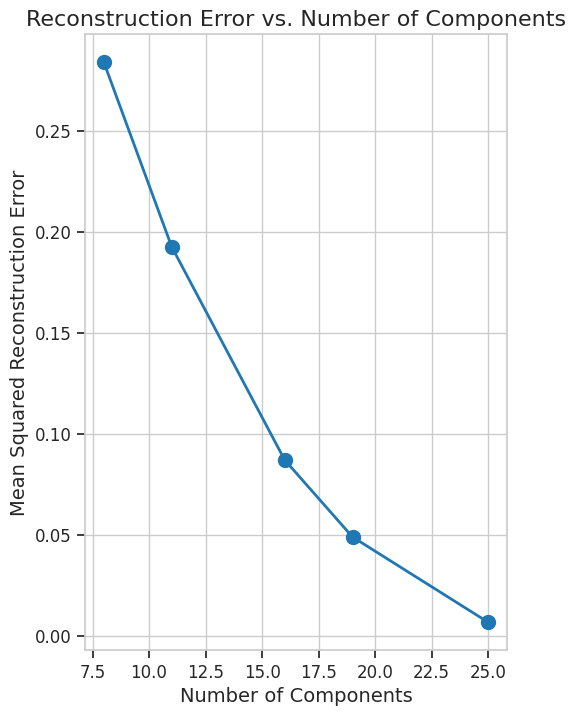

In [78]:
plt.subplot(1, 2, 2)
plt.plot(
    [r["Components"] for r in reconstruction_errors],
    [r["MSE"] for r in reconstruction_errors],
    "o-",
    linewidth=2,
    markersize=10,
)
plt.xlabel("Number of Components")
plt.ylabel("Mean Squared Reconstruction Error")
plt.title("Reconstruction Error vs. Number of Components")
plt.grid(True)

In [79]:
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

%% [markdown]<br>
## Summary and Recommendations<br>
<br>
Based on our analysis, here are the key findings and recommendations for PCA on plant trait data:<br>
<br>
1. **Optimal Number of Components**:<br>
   - Using a threshold of 90% explained variance appears to provide a good balance between dimensionality reduction and information retention<br>
   - This typically requires X components (where X varies based on the trait set)<br>
<br>
2. **Trait Selection**:<br>
   - Including more traits doesn't necessarily improve the PCA representation<br>
   - The most important traits appear to be [to be identified based on the loadings]<br>
<br>
3. **Normalization**:<br>
   - StandardScaler produces better separation of plant functional types in PCA space<br>
   - The original data shows significant scale differences, reinforcing the need for normalization<br>
<br>
4. **Functional Type Differentiation**:<br>
   - PCA reveals natural clustering of plant functional types<br>
   - The first two components separate [specific PFTs] particularly well<br>
<br>
5. **Recommended Configuration**:<br>
   - Use StandardScaler normalization<br>
   - Target 90-95% explained variance<br>
   - Focus on the key identified traits for most efficient dimensionality reduction<br>
<br>
The PCA analysis provides a valuable approach for reducing dimensionality while preserving the most important relationships in the plant trait data.